# Dataset overview

- **Link**: https://www.kaggle.com/datasets/falgunipatel19/biomedical-text-publication-classification
- **Purpose:** Biomedical text document classification  
- **Document types:** Abstracts and full papers (≤6 pages used previously); this dataset focuses on **long research papers (>6 pages)**  
- **Content:** Cancer-related documents  
- **Classification task:** Categorize documents into **3 classes**:  
  - `Thyroid_Cancer`  
  - `Colon_Cancer`  
  - `Lung_Cancer`  
- **Total publications:** 7,569  
- **Number of samples per class:**  
  - Colon Cancer: 2,579  
  - Lung Cancer: 2,180  
  - Thyroid Cancer: 2,810  
- **Intended use:** Document classification


# Importing


In [1]:
!pip install gensim

In [2]:
!pip install nltk

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [5]:
import re
import nltk

from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

from sklearn.decomposition import PCA
from wordcloud import WordCloud
from collections import Counter
from textblob import TextBlob
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

import tensorflow as tf
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
import time


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Loading Dataset

In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("falgunipatel19/biomedical-text-publication-classification")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'biomedical-text-publication-classification' dataset.
Path to dataset files: /kaggle/input/biomedical-text-publication-classification


In [7]:
csv_path = os.path.join(path, "alldata_1_for_kaggle.csv")
df = pd.read_csv(csv_path, encoding='latin1')

print("✅ Dataset loaded successfully!")
print("Shape:", df.shape)
df.head()


✅ Dataset loaded successfully!
Shape: (7570, 3)


,Unnamed: 0,0,a
0,0,Thyroid_Cancer,Thyroid surgery in children in a single insti...
1,1,Thyroid_Cancer,""" The adopted strategy was the same as that us..."
2,2,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...
3,3,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...
4,4,Thyroid_Cancer,This study aimed to investigate serum matrix ...


# EDA

## Basic Information

In [8]:
df.head()

,Unnamed: 0,0,a
0,0,Thyroid_Cancer,Thyroid surgery in children in a single insti...
1,1,Thyroid_Cancer,""" The adopted strategy was the same as that us..."
2,2,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...
3,3,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...
4,4,Thyroid_Cancer,This study aimed to investigate serum matrix ...


## Drop unnamed column and change column names

In [9]:
df=df.drop('Unnamed: 0',axis=1)

In [10]:
df = df.rename(columns={'0': 'Target','a':'Text'})

In [11]:
df

,Target,Text
0,Thyroid_Cancer,Thyroid surgery in children in a single insti...
1,Thyroid_Cancer,""" The adopted strategy was the same as that us..."
2,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...
3,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...
4,Thyroid_Cancer,This study aimed to investigate serum matrix ...
...,...,...
7565,Colon_Cancer,we report the case of a 24yearold man who pres...
7566,Colon_Cancer,among synchronous colorectal cancers scrcs rep...
7567,Colon_Cancer,the heterogeneity of cancer cells is generally...
7568,Colon_Cancer,"""adipogenesis is the process through which mes..."


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7570 entries, 0 to 7569
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Target  7570 non-null   object
 1   Text    7570 non-null   object
dtypes: object(2)
memory usage: 118.4+ KB


## Category Distibution


Here we can see that 3 classes has almost the same frequency

In [13]:
df['Target'].unique()

array(['Thyroid_Cancer', 'Colon_Cancer', 'Lung_Cancer'], dtype=object)

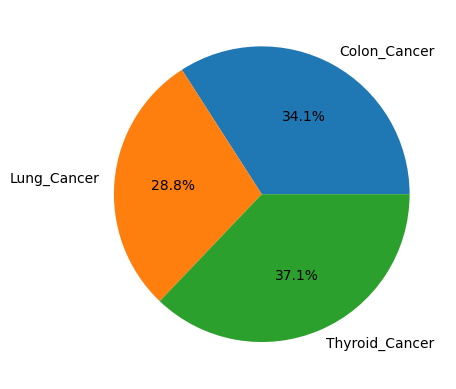

In [14]:
plt.pie(df.groupby('Target')['Target'].count(),autopct="%.1f%%",labels=['Colon_Cancer', 'Lung_Cancer', 'Thyroid_Cancer'])
plt.show()

## Word count distribution

This is the distribution of wordcount per text, we can see that text usually have length of 4200 - 4800 words


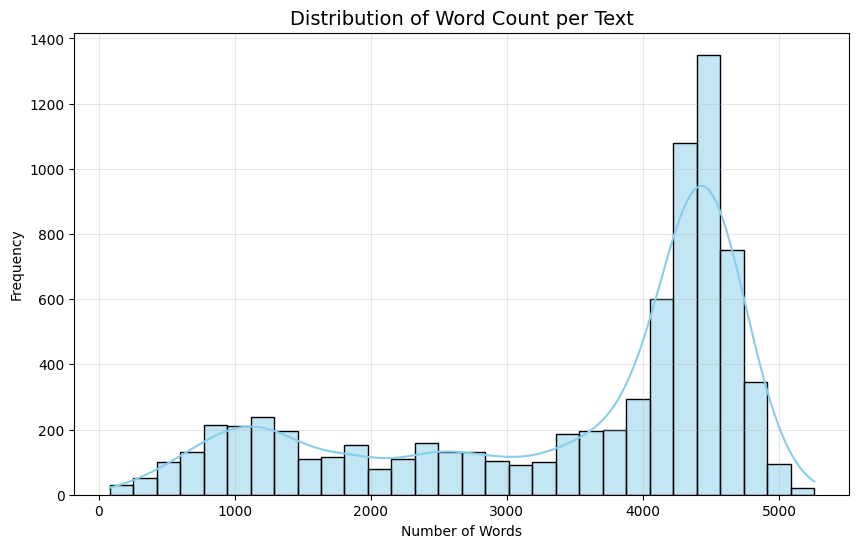

In [15]:
word_lengths = df['Text'].apply(lambda x: len(x.split()))

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(word_lengths, bins=30, kde=True, color='skyblue')

plt.title('Distribution of Word Count per Text', fontsize=14)
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.show()

- The Thyroid_Cancer and Colon_Cancer datasets have homogeneous text lengths, potentially easier for modeling.

- The Lung_Cancer dataset shows greater variation, suggesting diverse text sources or preprocessing differences.

- All distributions tail off beyond 5000 words, implying few extremely long samples.

- The density overlap between red and blue curves shows strong similarity, while green diverges significantly.

## Word count Distribution by class

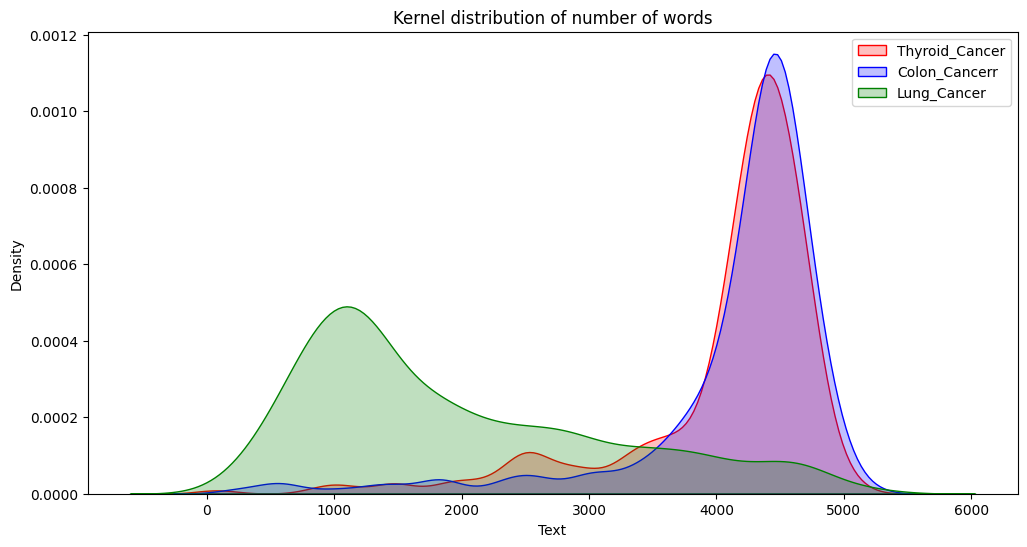

In [16]:
num_1 = df[df['Target']== 'Thyroid_Cancer']['Text'].apply(lambda x: len(x.split()))
num_2 = df[df['Target']== 'Colon_Cancer']['Text'].apply(lambda x: len(x.split()))
num_3 = df[df['Target']== 'Lung_Cancer']['Text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(12,6))
sns.kdeplot(num_1, shade=True, color = 'red').set_title('Kernel distribution of number of words')
sns.kdeplot(num_2, shade=True, color = 'blue')
sns.kdeplot(num_3, shade=True, color = 'green')

plt.legend(labels=['Thyroid_Cancer', 'Colon_Cancerr', 'Lung_Cancer'])

In [17]:
df['word_count'] = df['Text'].apply(lambda x: len(str(x).split()))
df['char_count'] = df['Text'].apply(lambda x: len(str(x)))
df['avg_word_length'] = df['char_count'] / df['word_count']


* The three cancer types show **distinct text length distributions**, reflecting differences in document detail and structure.
* **Thyroid_Cancer** and **Colon_Cancer** have **similar, consistently long texts** (median ≈ 4300–4500 words), suggesting standardized reporting styles.
* **Lung_Cancer** texts are **shorter and more variable**, ranging from brief notes to long reports, indicating diverse documentation.
* **Outliers** appear in all groups, especially in Thyroid and Colon Cancer, likely representing unusually short or special-format entries.

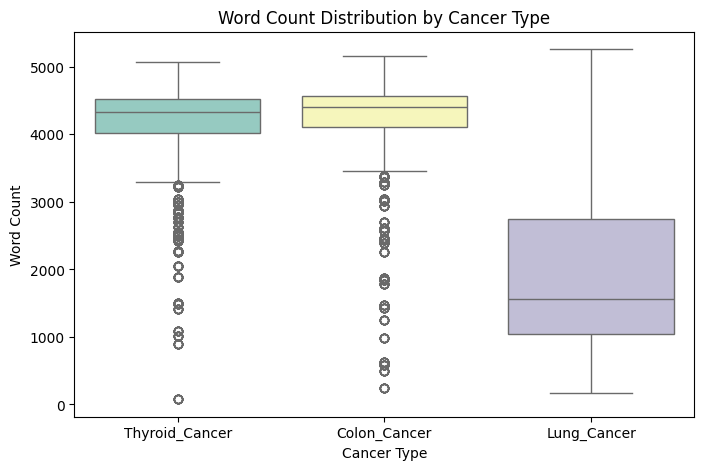

In [18]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='Target', y='word_count', palette='Set3')
plt.title('Word Count Distribution by Cancer Type')
plt.xlabel('Cancer Type')
plt.ylabel('Word Count')
plt.show()

## Stop words Distribution

This is where we will check the distribution of our stop words.

High stop word percentage (30-32%) is normal for natural text

🔢 Total words: 26,380,989
🛑 Total stopwords: 8,165,681 (30.95%)


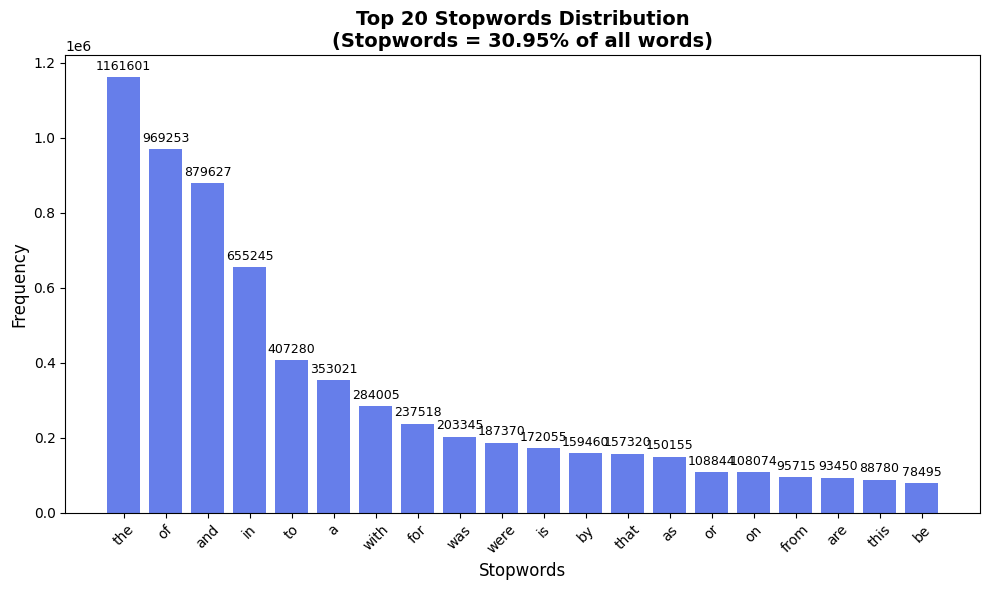

In [19]:
# Define English stopwords
stop_words = set(stopwords.words('english'))

# Count all stopwords in dataset
all_words = ' '.join(df['Text']).lower().split()
stopword_counts = Counter([w for w in all_words if w in stop_words])

# Convert to DataFrame-friendly lists
words = list(stopword_counts.keys())
counts = list(stopword_counts.values())

# Calculate percentage of stopwords in dataset
total_words = len(all_words)
total_stopwords = sum(counts)
percentage = (total_stopwords / total_words) * 100

print(f"🔢 Total words: {total_words:,}")
print(f"🛑 Total stopwords: {total_stopwords:,} ({percentage:.2f}%)")

# Select top 20 most common stopwords
top_n = 20
top_stopwords = stopword_counts.most_common(top_n)
top_words = [w for w, _ in top_stopwords]
top_counts = [c for _, c in top_stopwords]

# Plot vertical bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(top_words, top_counts, color='#667eea')

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + max(top_counts)*0.01,
             f"{height}", ha='center', va='bottom', fontsize=9)

plt.title(f"Top {top_n} Stopwords Distribution\n(Stopwords = {percentage:.2f}% of all words)",
          fontsize=14, fontweight='bold')
plt.xlabel("Stopwords", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Top words by target

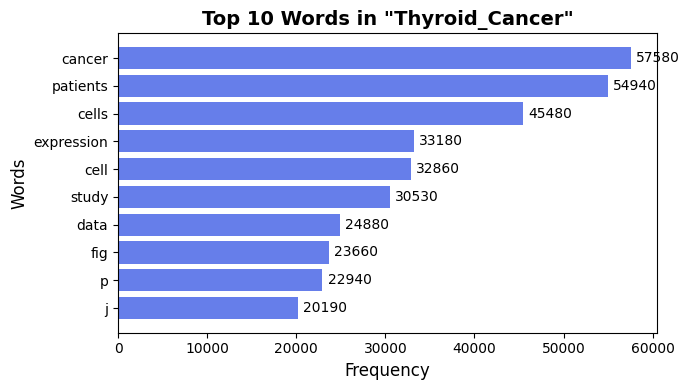

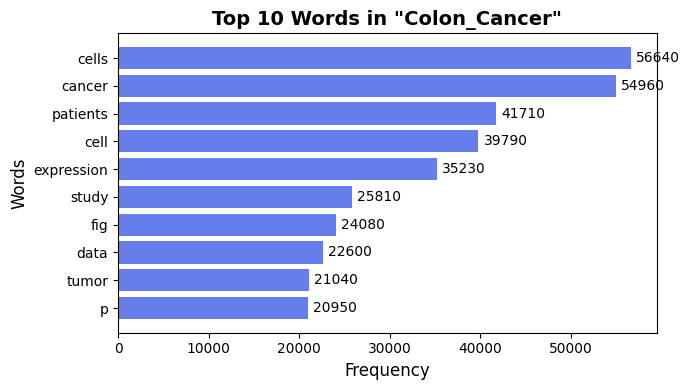

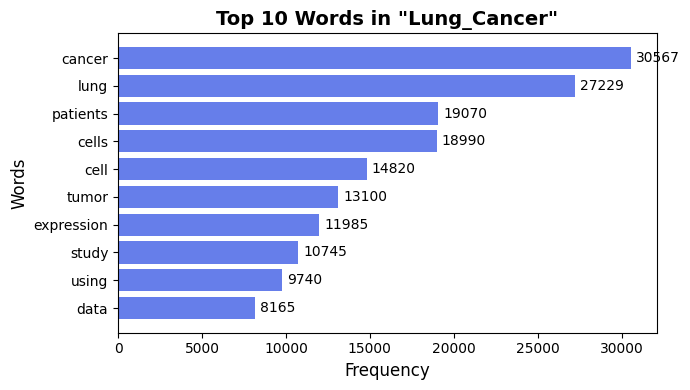

In [20]:

stop_words = set(stopwords.words('english'))

def get_top_words(texts, n=10):
    words = ' '.join(texts).lower().split()
    words = [w for w in words if w.isalpha() and w not in stop_words]
    return Counter(words).most_common(n)

# Loop through each target
for target in df['Target'].unique():
    top_words = get_top_words(df[df['Target'] == target]['Text'])
    words_list = [w for w, _ in top_words]
    counts_list = [c for _, c in top_words]

    # Plot
    plt.figure(figsize=(7, 4))
    plt.barh(words_list, counts_list, color='#667eea')
    plt.xlabel('Frequency', fontsize=12)
    plt.ylabel('Words', fontsize=12)
    plt.title(f'Top {len(words_list)} Words in "{target}"', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()  # Top word appears on top

    # Add text labels to bars
    for i, v in enumerate(counts_list):
        plt.text(v + max(counts_list)*0.01, i, str(v), va='center', fontsize=10)

    plt.tight_layout()
    plt.show()

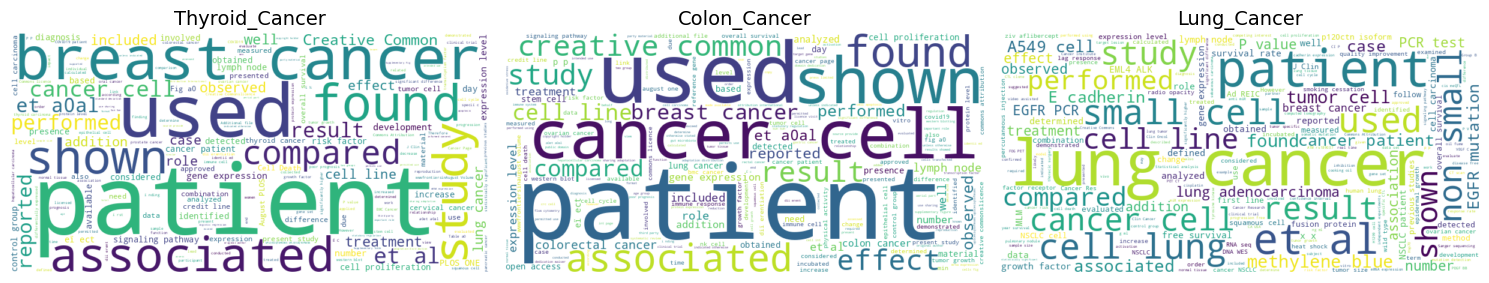

In [21]:
plt.figure(figsize=(15, 5))
for i, target in enumerate(df['Target'].unique(), 1):
    text = ' '.join(df[df['Target'] == target]['Text'].astype(str))
    wc = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words).generate(text)
    plt.subplot(1, len(df['Target'].unique()), i)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(target, fontsize=14)

plt.tight_layout()
plt.show()

We see that the top words in each class share the same words like: cancer, cells, patients


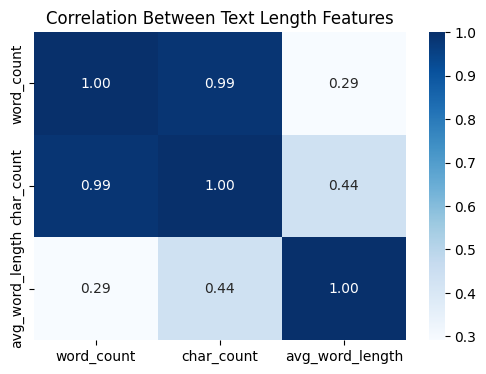

In [22]:
plt.figure(figsize=(6, 4))
sns.heatmap(df[['word_count', 'char_count', 'avg_word_length']].corr(), annot=True, cmap='Blues', fmt='.2f')
plt.title('Correlation Between Text Length Features')
plt.show()

avg_word_length offers unique value — it reflects linguistic complexity, not just size.

For downstream tasks (e.g., classification), a good numeric feature set could be:

- word_count (text length proxy)

- avg_word_length (complexity proxy)

## N gram analysis (Bigram)

Here we will check the N gram, but the result usually have common words, we will remove them for clear visuallization

- Extracts the top bigrams for each class (Target),

- Detects common bigrams that appear across all classes, and

- Removes those common bigrams so only distinctive bigrams for each class **remain**.

🧩 Common bigrams across all classes: 10 found


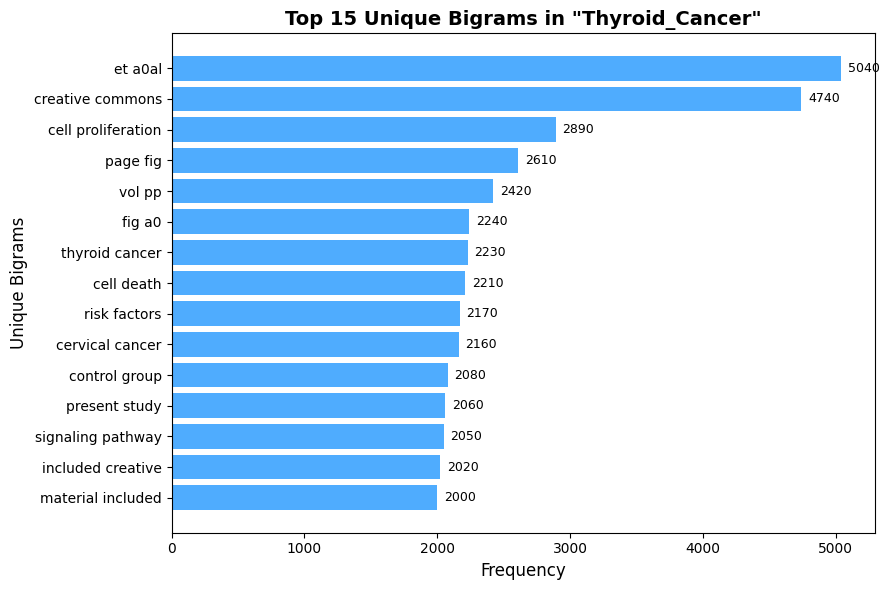

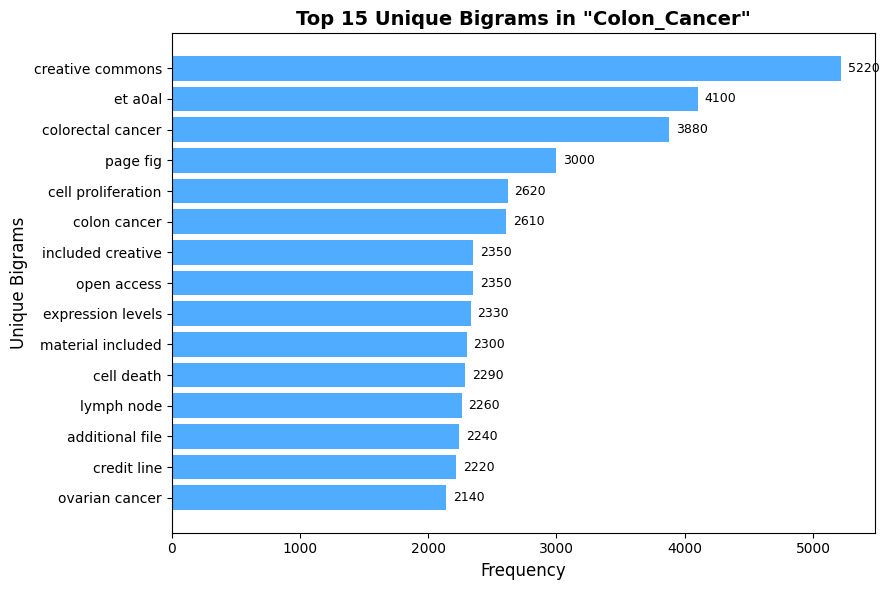

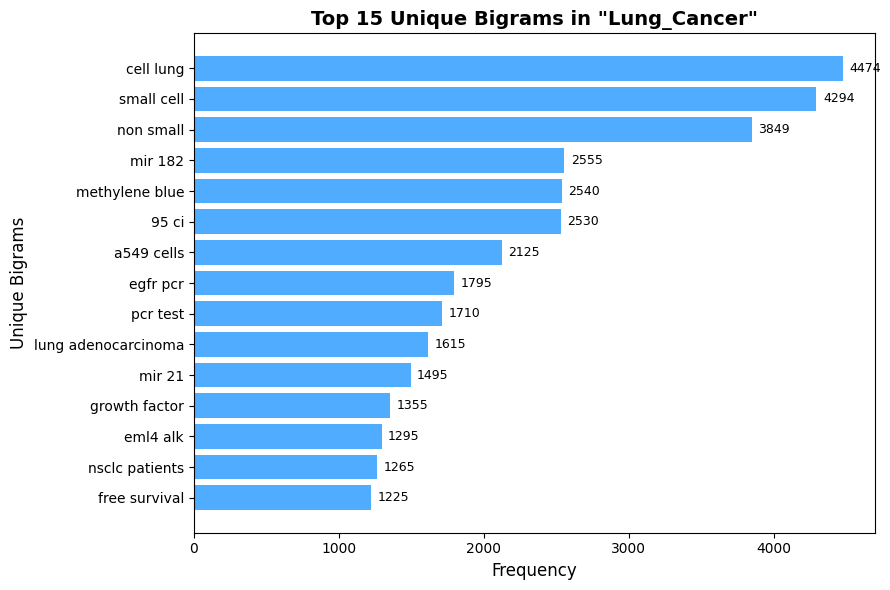

In [23]:

def get_top_bigrams(texts, n=30):
    vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
    X = vectorizer.fit_transform(texts)
    counts = np.asarray(X.sum(axis=0)).flatten()
    bigrams = vectorizer.get_feature_names_out()
    bigram_freq = sorted(list(zip(bigrams, counts)), key=lambda x: x[1], reverse=True)
    return bigram_freq[:n]

# Step 1: Collect top bigrams per target
bigrams_by_target = {}
for target in df['Target'].unique():
    texts = df[df['Target'] == target]['Text']
    bigrams_by_target[target] = get_top_bigrams(texts)

# Step 2: Find common bigrams across all classes
bigram_sets = [set([b for b, _ in bigrams]) for bigrams in bigrams_by_target.values()]
common_bigrams = set.intersection(*bigram_sets)
print(f"🧩 Common bigrams across all classes: {len(common_bigrams)} found")

# Step 3: Remove common bigrams and plot remaining
for target, bigrams in bigrams_by_target.items():
    # Filter out common bigrams
    unique_bigrams = [(b, c) for b, c in bigrams if b not in common_bigrams][:15]

    bigram_list = [b for b, _ in unique_bigrams]
    count_list = [c for _, c in unique_bigrams]

    # Plot
    plt.figure(figsize=(9, 6))
    plt.barh(bigram_list, count_list, color='#4facfe')
    plt.xlabel('Frequency', fontsize=12)
    plt.ylabel('Unique Bigrams', fontsize=12)
    plt.title(f'Top 15 Unique Bigrams in "{target}"', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()

    # Add text labels
    for i, v in enumerate(count_list):
        plt.text(v + max(count_list)*0.01, i, str(v), va='center', fontsize=9)

    plt.tight_layout()
    plt.show()

Because these are all cancers's documnents so we have a lot of words in common


## TF IDF

### Top words by TF IDF

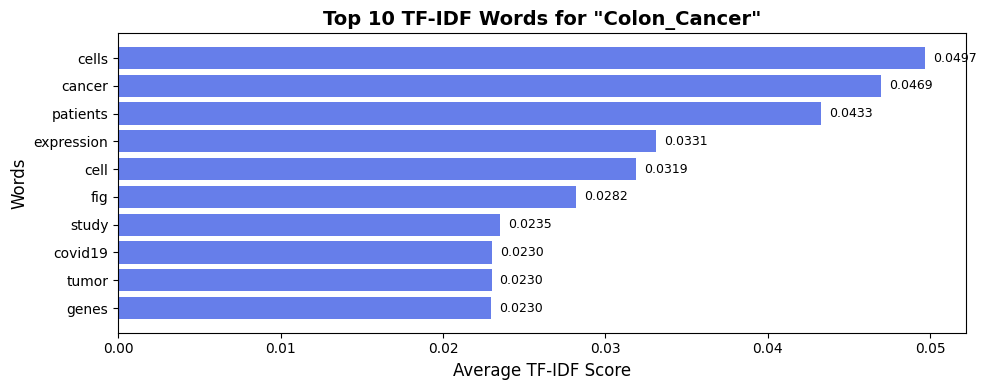

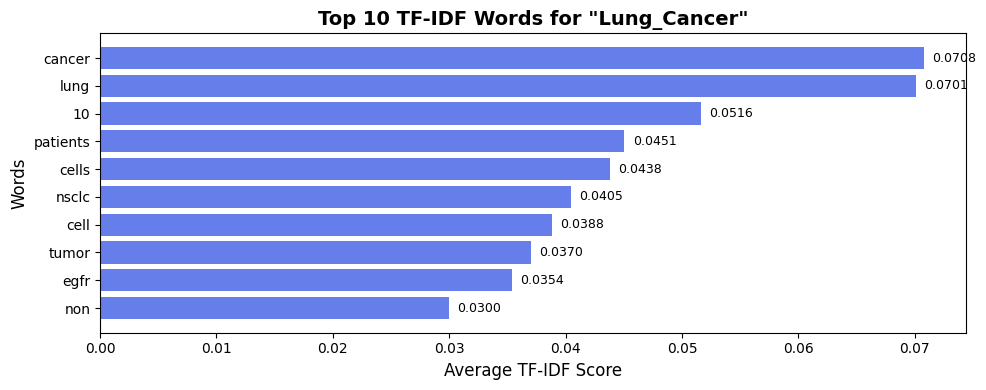

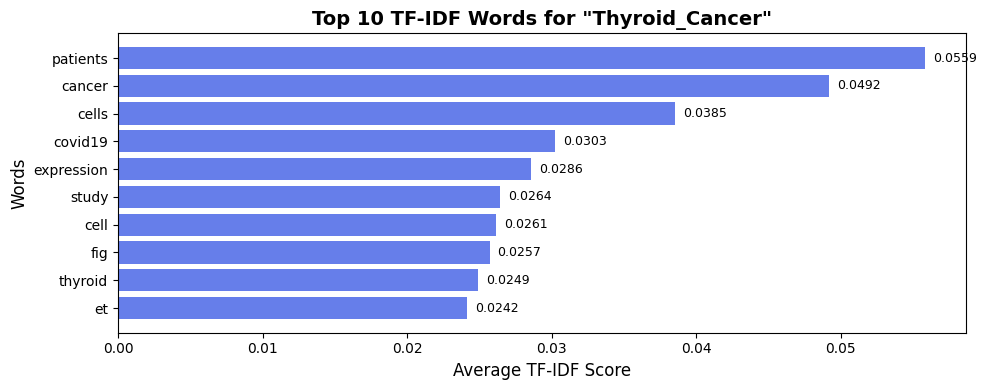

In [24]:

# Compute TF-IDF
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
X = tfidf.fit_transform(df['Text'])
tfidf_df = pd.DataFrame(X.toarray(), columns=tfidf.get_feature_names_out())

# Compute mean TF-IDF per label
tfidf_by_label = (
    df['Target'].to_frame()
    .join(tfidf_df)
    .groupby('Target')
    .mean()
    .T
)

# Plot top words per label
for label in tfidf_by_label.columns:
    top_words = tfidf_by_label[label].sort_values(ascending=False).head(10)
    words = top_words.index
    scores = top_words.values

    # Plot horizontal bar chart
    plt.figure(figsize=(10, 4))
    plt.barh(words, scores, color='#667eea')
    plt.xlabel('Average TF-IDF Score', fontsize=12)
    plt.ylabel('Words', fontsize=12)
    plt.title(f'Top 10 TF-IDF Words for "{label}"', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()

    # Add text labels
    for i, v in enumerate(scores):
        plt.text(v + max(scores) * 0.01, i, f"{v:.4f}", va='center', fontsize=9)

    plt.tight_layout()
    plt.show()

### PCA visualization of TF IDF embeddings

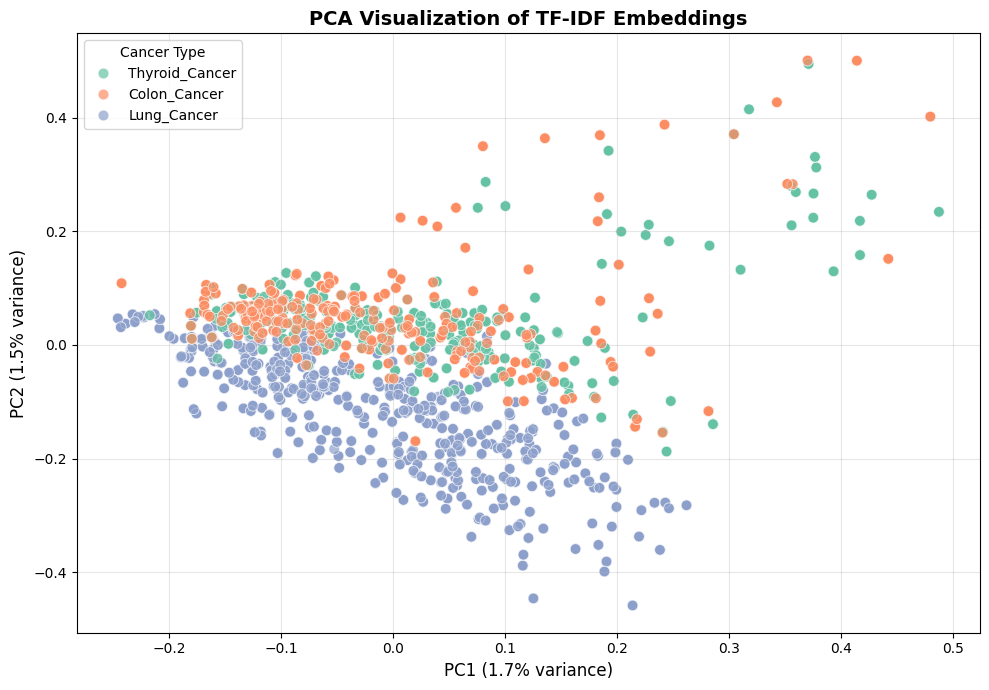


📊 Explained Variance:
   PC1: 1.70%
   PC2: 1.53%
   Total: 3.24%


In [25]:
# Check if Target is numeric (0,1,2) or already text labels
if df['Target'].dtype in ['int64', 'int32', 'float64']:
    # Map numeric labels to text labels
    label_map = {0: 'Thyroid_Cancer', 1: 'Colon_Cancer', 2: 'Lung_Cancer'}
    df['Target_mapped'] = df['Target'].map(label_map)
else:
    # Target is already text, just copy it
    df['Target_mapped'] = df['Target'].copy()

# Apply PCA to reduce TF-IDF features to 2 dimensions for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X.toarray())

# Visualize the PCA results
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['Target_mapped'],
                palette='Set2', alpha=0.7, s=60)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=12)
plt.title('PCA Visualization of TF-IDF Embeddings', fontsize=14, fontweight='bold')
plt.legend(title='Cancer Type', loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n📊 Explained Variance:")
print(f"   PC1: {pca.explained_variance_ratio_[0]*100:.2f}%")
print(f"   PC2: {pca.explained_variance_ratio_[1]*100:.2f}%")
print(f"   Total: {sum(pca.explained_variance_ratio_)*100:.2f}%")

Based on the PCA result

- Class Lung cancer cluster separate well → texts are distinct for class  Lung cancer type.

- Thyroid and Colon cancer are overlap → texts share many common medical terms


# Preprocessing for training

## Tokenization

In this pipeline, we prepare raw text for Natural Language Processing (NLP) by applying several cleaning and normalization steps before tokenization:

1. **Remove unwanted characters**

   * Using `clean_text()`, all non-alphabetic characters (numbers, punctuation, symbols) are removed.
   * The regex pattern `[^a-zA-Z\s]` ensures only English letters and spaces remain.

2. **Remove stopwords and custom words**

   * `clean_stopword()` filters out common English stopwords from NLTK’s list.
   * It also excludes domain-specific terms like `"Colon_Cancer"`, `"Lung_Cancer"`, and `"Thyroid_Cancer"` to avoid bias in later analysis.
   * The text is then converted to lowercase for consistency.

3. **Tokenization**

   * Finally, `tokenize()` splits the cleaned text into individual words (tokens) using NLTK’s `word_tokenize()`.
   * Each token represents a meaningful unit that can be used for **TF-IDF**, **word frequency analysis**, or **machine learning models**.



In [26]:
def clean_text(d):
    pattern = r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', d)
    return text

names = ['Colon_Cancer', 'Lung_Cancer', 'Thyroid_Cancer']

def clean_stopword(d):
    stop_words = stopwords.words('english')
    for name in names:
        stop_words.append(name)
    return " ".join([w.lower() for w in d.split() if w.lower() not in stop_words and len(w) > 1])

def tokenize(d):
    return word_tokenize(d)

In [27]:
df['final_text']= df.Text.apply(clean_text).apply(clean_stopword).apply(tokenize)
df.final_text.head()

,final_text
0,"[thyroid, surgery, children, single, instituti..."
1,"[adopted, strategy, used, prior, years, based,..."
2,"[coronary, arterybypass, grafting, thrombosis,..."
3,"[solitary, plasmacytoma, sp, skull, uncommon, ..."
4,"[study, aimed, investigate, serum, matrix, met..."


In [28]:
print(" ".join(df.final_text[0]),'\n')
print(" ".join(df.final_text[10]),'\n')
print(" ".join(df.final_text[100]),'\n')
print(" ".join(df.final_text[1000]),'\n')
print(" ".join(df.final_text[7000]))

thyroid surgery children single institution osama ibrahim almosallama ali aseerib ahmed alhumaida ali alzahranic saif alsobhib saud alshanafeybfrom adepartment surgery college medicine qassim university buraidah al qassim saudi arabia bdepartment surgery king faisal specialist hospital research center riyadh saudi arabia cdepartment medicine king faisal specialist hospital research center riyadh saudi arabia correspondence dr osama ibrahim almosallam department surgery college medicine qassim university po box buraidah al qassim saudi arabia osamaiaahotmailcom orcid orcid citation almosallam oi aseeri alhumaid alzahrani alsobhi alshanafey thyroid surgery children single institution ann saudi med received january accepted may published august copyright copyright annals saudi medicine saudi arabia access creative commons attributionnoncommercialnoderivatives international license cc byncnd details accessed httpcreativecommons licensesbyncndfunding nonebackground data thyroid surgery chil

In [29]:
df.head()

,Target,Text,word_count,char_count,avg_word_length,Target_mapped,final_text
0,Thyroid_Cancer,Thyroid surgery in children in a single insti...,2871,20707,7.212470,Thyroid_Cancer,"[thyroid, surgery, children, single, instituti..."
1,Thyroid_Cancer,""" The adopted strategy was the same as that us...",2494,17018,6.823577,Thyroid_Cancer,"[adopted, strategy, used, prior, years, based,..."
2,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...,2954,21622,7.319567,Thyroid_Cancer,"[coronary, arterybypass, grafting, thrombosis,..."
3,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...,1880,13860,7.372340,Thyroid_Cancer,"[solitary, plasmacytoma, sp, skull, uncommon, ..."
4,Thyroid_Cancer,This study aimed to investigate serum matrix ...,3037,23696,7.802437,Thyroid_Cancer,"[study, aimed, investigate, serum, matrix, met..."


In [30]:
for i in range(len(df)):
    df['final_text'][i] = " ".join(df['final_text'][i])

In [31]:
df['final_text'][:3]

,final_text
0,thyroid surgery children single institution os...
1,adopted strategy used prior years based four e...
2,coronary arterybypass grafting thrombosis brin...


Here we label encoding the labels

In [32]:
df['Target']= df['Target'].replace(['Thyroid_Cancer', 'Colon_Cancer', 'Lung_Cancer'],[0,1,2])

In [33]:
df

,Target,Text,word_count,char_count,avg_word_length,Target_mapped,final_text
0,0,Thyroid surgery in children in a single insti...,2871,20707,7.212470,Thyroid_Cancer,thyroid surgery children single institution os...
1,0,""" The adopted strategy was the same as that us...",2494,17018,6.823577,Thyroid_Cancer,adopted strategy used prior years based four e...
2,0,coronary arterybypass grafting thrombosis ï¬b...,2954,21622,7.319567,Thyroid_Cancer,coronary arterybypass grafting thrombosis brin...
3,0,Solitary plasmacytoma SP of the skull is an u...,1880,13860,7.372340,Thyroid_Cancer,solitary plasmacytoma sp skull uncommon clinic...
4,0,This study aimed to investigate serum matrix ...,3037,23696,7.802437,Thyroid_Cancer,study aimed investigate serum matrix metallopr...
...,...,...,...,...,...,...,...
7565,1,we report the case of a 24yearold man who pres...,1429,11219,7.850945,Colon_Cancer,report case yearold man presented chief compla...
7566,1,among synchronous colorectal cancers scrcs rep...,1252,9085,7.256390,Colon_Cancer,among synchronous colorectal cancers scrcs rep...
7567,1,the heterogeneity of cancer cells is generally...,4510,32373,7.178049,Colon_Cancer,heterogeneity cancer cells generally accepted ...
7568,1,"""adipogenesis is the process through which mes...",4051,32390,7.995557,Colon_Cancer,adipogenesis process mesenchymalstem cells msc...


## Vectorization



In [34]:
X = df.final_text
y = df.Target

Here we split train/test dataset

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 4)

In [36]:
def tfidf(words):
    tfidf_vectorizer = TfidfVectorizer()
    data_feature = tfidf_vectorizer.fit_transform(words)
    return data_feature, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train.tolist())
X_test_tfidf = tfidf_vectorizer.transform(X_test.tolist())

In [37]:
X_train_tfidf.shape

(6056, 177635)

# Training

In [38]:
def score_metrics(y_test, y_predicted, model_name="Model"):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='macro')
    recall = recall_score(y_test, y_predicted, average='macro')
    print(f"{model_name}")
    print(f"Accuracy = {accuracy:.3f}, Precision = {precision:.3f}, Recall = {recall:.3f}")
    print("-" * 50)

    # Return as a dictionary (not tuple)
    return {
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall
    }

In [39]:
classes = ['Thyroid_Cancer', 'Colon_Cancer', 'Lung_Cancer']

def plot_confusion_matrix(y_test, y_predicted, title='Confusion Matrix'):
    cm = confusion_matrix(y_test, y_predicted)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d',
                xticklabels=classes,
                yticklabels=classes)
    plt.title(title, fontsize=14)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## TF IDF vectorization

Here we will train 2 model Logistic regression and Random forest using TF IDF vectorization

### Logistic Regression

In [40]:
lr_tfidf = LogisticRegression(random_state=42,solver = 'liblinear')
lr_tfidf.fit(X_train_tfidf, y_train)
y_pred_lr_tfidf = lr_tfidf.predict(X_test_tfidf)

In [41]:
score_metrics(y_test, y_pred_lr_tfidf)

Model
Accuracy = 0.954, Precision = 0.957, Recall = 0.957
--------------------------------------------------


{'Model': 'Model',
 'Accuracy': 0.9537648612945839,
 'Precision': 0.9569716775599129,
 'Recall': 0.9570309839972762}

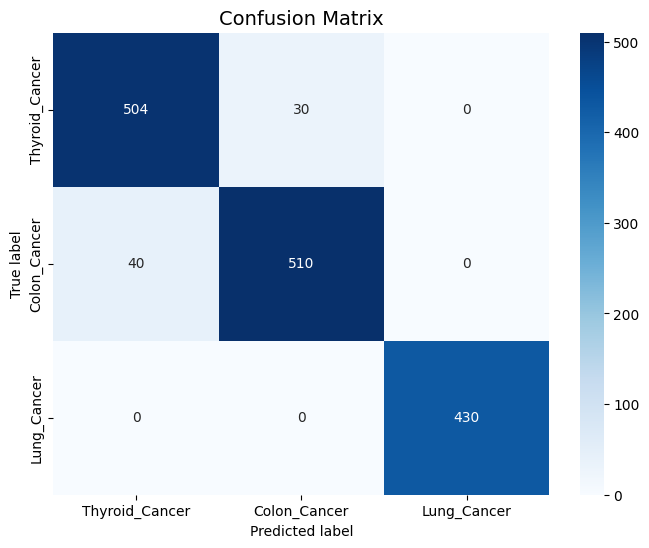

In [42]:
plot_confusion_matrix(y_test, y_pred_lr_tfidf)

### Random Forest

🌲 Random Forest
Accuracy = 0.999, Precision = 0.999, Recall = 0.999
--------------------------------------------------


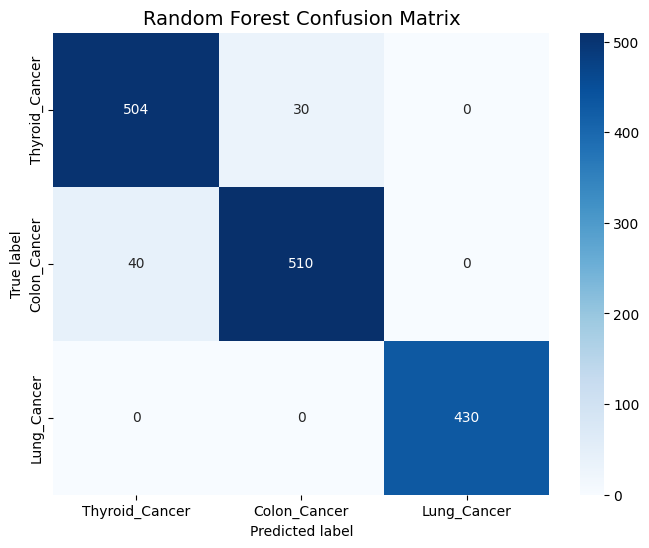

In [43]:
rf_tfidf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=10,
    n_jobs=-1
)
rf_tfidf_model.fit(X_train_tfidf, y_train)
y_pred_rf_tfidf = rf_tfidf_model.predict(X_test_tfidf)

# Evaluate Random Forest
rf_tfidf_results = score_metrics(y_test, y_pred_rf_tfidf, model_name="🌲 Random Forest")
plot_confusion_matrix(y_test, y_pred_lr_tfidf, title="Random Forest Confusion Matrix")

### Compare result using TF IDF vectorizer

In [44]:
lr_tfidf_results = score_metrics(y_test, y_pred_lr_tfidf, "⚙️ Logistic Regression")
rf_tfidf_results = score_metrics(y_test, y_pred_rf_tfidf, "🌲 Random Forest")

⚙️ Logistic Regression
Accuracy = 0.954, Precision = 0.957, Recall = 0.957
--------------------------------------------------
🌲 Random Forest
Accuracy = 0.999, Precision = 0.999, Recall = 0.999
--------------------------------------------------


* **Random Forest** outperformed **Logistic Regression** across all metrics.
* Both models achieved **very high accuracy**, but Random Forest was nearly perfect.
* **Precision** and **Recall** for Random Forest were also slightly higher, indicating stronger consistency in both identifying and retrieving correct classes.
* Logistic Regression performed well, but it showed a small gap—suggesting it may generalize slightly less effectively on this dataset.

                    Model  Accuracy  Precision    Recall
0  ⚙️ Logistic Regression  0.953765   0.956972  0.957031
1         🌲 Random Forest  0.999339   0.999227  0.999376


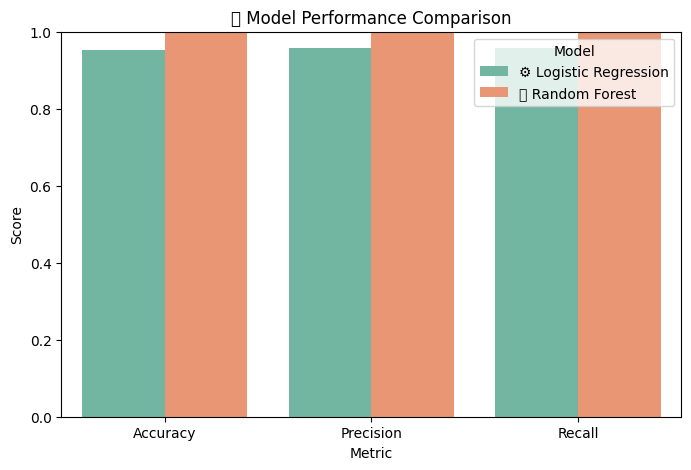

In [45]:
results_df = pd.DataFrame([lr_tfidf_results, rf_tfidf_results])
print(results_df)

# 4️⃣ Visualize Comparison
plt.figure(figsize=(8,5))
sns.barplot(data=results_df.melt(id_vars=["Model"], var_name="Metric", value_name="Score"),
            x="Metric", y="Score", hue="Model", palette="Set2")
plt.title("📊 Model Performance Comparison")
plt.ylim(0, 1)
plt.legend(title="Model")
plt.show()

## Count Vectorization

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [47]:
def count_vectorize(texts):
    vectorizer = CountVectorizer(stop_words='english', max_features=5000)
    X_features = vectorizer.fit_transform(texts)
    return X_features, vectorizer

X_train_count, count_vectorizer = count_vectorize(X_train.tolist())
X_test_count = count_vectorizer.transform(X_test.tolist())

### Logistic Regression

⚙️ Logistic Regression (Count)
Accuracy = 1.000, Precision = 1.000, Recall = 1.000
--------------------------------------------------


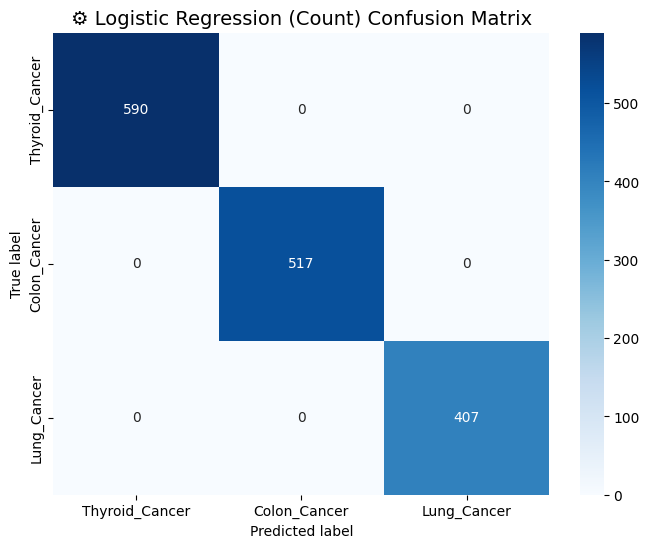

In [48]:
lr_count = LogisticRegression(random_state=42, solver='liblinear')
lr_count.fit(X_train_count, y_train)
y_pred_lr_count = lr_count.predict(X_test_count)

lr_count_results = score_metrics(y_test, y_pred_lr_count, model_name="⚙️ Logistic Regression (Count)")
plot_confusion_matrix(y_test, y_pred_lr_count, title="⚙️ Logistic Regression (Count) Confusion Matrix")


### Random Forest

🌲 Random Forest (Count)
Accuracy = 0.997, Precision = 0.997, Recall = 0.998
--------------------------------------------------


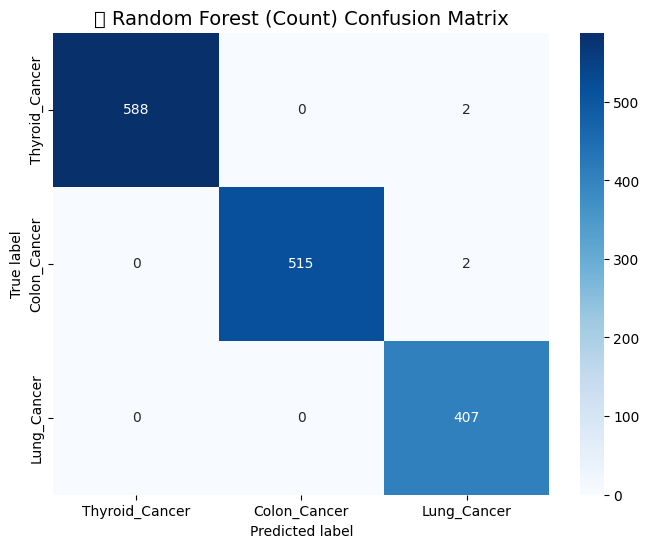

In [49]:
rf_count = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=10,
    n_jobs=-1
)
rf_count.fit(X_train_count, y_train)
y_pred_rf_count = rf_count.predict(X_test_count)

rf_count_results = score_metrics(y_test, y_pred_rf_count, model_name="🌲 Random Forest (Count)")
plot_confusion_matrix(y_test, y_pred_rf_count, title="🌲 Random Forest (Count) Confusion Matrix")


### Compare result with Count Vectorizer

                            Model  Accuracy  Precision    Recall
0  ⚙️ Logistic Regression (Count)  1.000000   1.000000  1.000000
1         🌲 Random Forest (Count)  0.997358   0.996756  0.997581


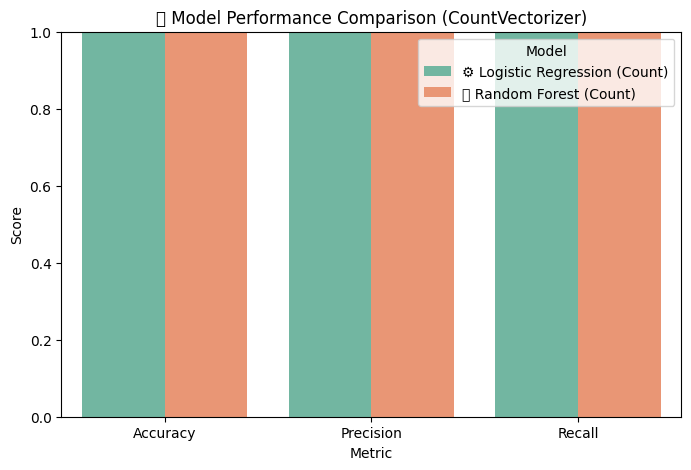

In [50]:
results_count_df = pd.DataFrame([lr_count_results, rf_count_results])
print(results_count_df)

plt.figure(figsize=(8,5))
sns.barplot(
    data=results_count_df.melt(id_vars=["Model"], var_name="Metric", value_name="Score"),
    x="Metric", y="Score", hue="Model", palette="Set2"
)
plt.title("📊 Model Performance Comparison (CountVectorizer)")
plt.ylim(0, 1)
plt.legend(title="Model")
plt.show()

## Compare Training result

📊 COMPLETE MODEL COMPARISON RESULTS
                         Model  Accuracy  Precision   Recall
⚙️ Logistic Regression (Count)  1.000000   1.000000 1.000000
       🌲 Random Forest (Count)  0.997358   0.996756 0.997581
        ⚙️ Logistic Regression  0.953765   0.956972 0.957031
               🌲 Random Forest  0.999339   0.999227 0.999376


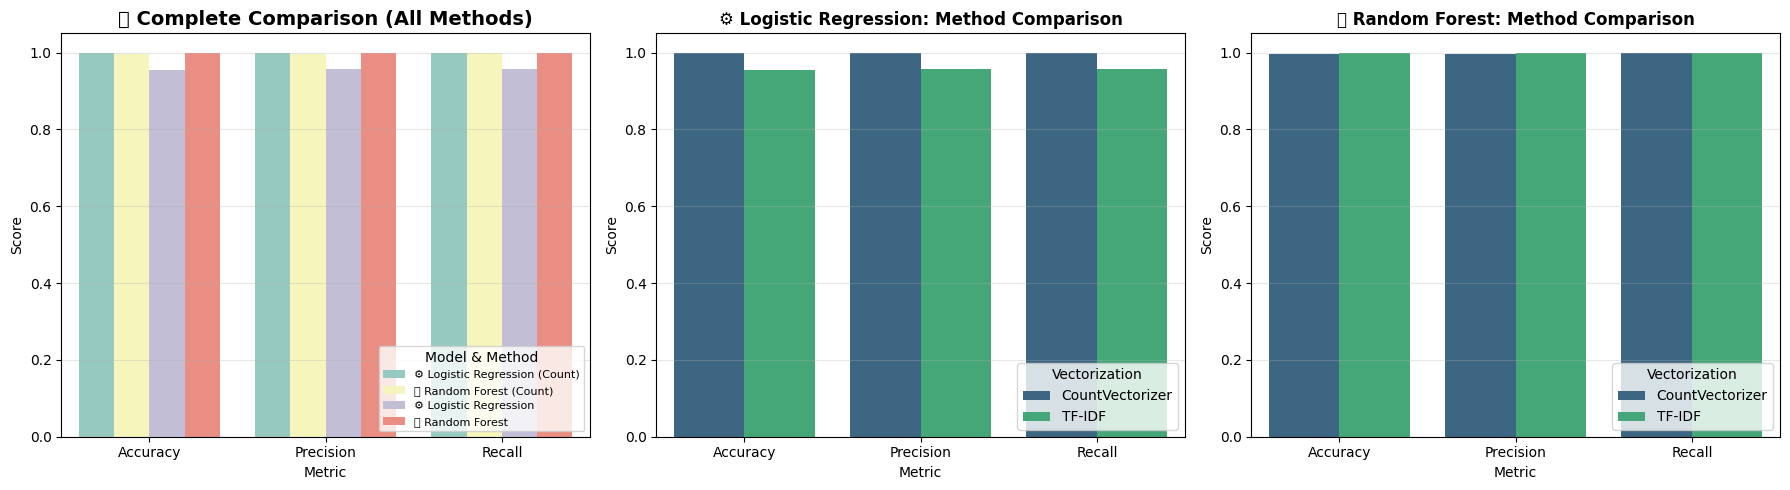

In [51]:
# Combine all results
all_results_df = pd.DataFrame([lr_count_results, rf_count_results,
                                lr_tfidf_results, rf_tfidf_results])

print("="*70)
print("📊 COMPLETE MODEL COMPARISON RESULTS")
print("="*70)
print(all_results_df.to_string(index=False))
print("="*70)

# Create 3 visualizations
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Overall Comparison (All Models & Methods)
melted_df = all_results_df.melt(id_vars=["Model"], var_name="Metric", value_name="Score")
sns.barplot(data=melted_df, x="Metric", y="Score", hue="Model",
            palette="Set3", ax=axes[0])
axes[0].set_title("📊 Complete Comparison (All Methods)", fontsize=14, fontweight='bold')
axes[0].set_ylim(0, 1.05)
axes[0].legend(title="Model & Method", loc='lower right', fontsize=8)
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Logistic Regression Method Comparison
lr_comparison = pd.DataFrame([lr_count_results, lr_tfidf_results])
lr_comparison['Method'] = ['CountVectorizer', 'TF-IDF']
lr_melted = lr_comparison.melt(id_vars=["Method"],
                                value_vars=["Accuracy", "Precision", "Recall"],
                                var_name="Metric", value_name="Score")

sns.barplot(data=lr_melted, x="Metric", y="Score", hue="Method",
            palette="viridis", ax=axes[1])
axes[1].set_title("⚙️ Logistic Regression: Method Comparison", fontsize=12, fontweight='bold')
axes[1].set_ylim(0, 1.05)
axes[1].legend(title="Vectorization", loc='lower right')
axes[1].grid(axis='y', alpha=0.3)

# Plot 3: Random Forest Method Comparison
rf_comparison = pd.DataFrame([rf_count_results, rf_tfidf_results])
rf_comparison['Method'] = ['CountVectorizer', 'TF-IDF']
rf_melted = rf_comparison.melt(id_vars=["Method"],
                               value_vars=["Accuracy", "Precision", "Recall"],
                               var_name="Metric", value_name="Score")

sns.barplot(data=rf_melted, x="Metric", y="Score", hue="Method",
            palette="viridis", ax=axes[2])
axes[2].set_title("🌲 Random Forest: Method Comparison", fontsize=12, fontweight='bold')
axes[2].set_ylim(0, 1.05)
axes[2].legend(title="Vectorization", loc='lower right')
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

- **Logistic Regression with CountVectorizer achieved perfect scores** (100% accuracy, precision, and recall), which is exceptional and suggests the model captured all patterns effectively with simple word frequency features

- **Significant performance drop for Logistic Regression with TF-IDF** (~95% across all metrics), indicating that the normalized term weights may have actually reduced the model's discriminative power for this specific dataset

- **Random Forest shows consistently excellent performance** across both vectorization methods (99.7-99.9%), demonstrating the model's robustness and ability to handle different feature representations effectively

- **CountVectorizer outperformed TF-IDF for both models**, which is somewhat counterintuitive since TF-IDF typically provides better feature representation by reducing the impact of common words

- **The dramatic difference between vectorization methods for Logistic Regression** (100% vs 95%) suggests that raw word counts may contain important frequency information that gets lost in TF-IDF normalization for this particular classification task

# Summary

## EDA Key Insights

**What we did in EDA:**
- **Class Distribution Analysis**: Examined the balance of three cancer types (Colon, Lung, Thyroid), finding nearly equal representation (~34%, 29%, 37%) across classes, which is ideal for training without class imbalance issues
- **Text Length Analysis**: Analyzed word count distributions revealing that Thyroid and Colon Cancer texts are consistently long (4300-4500 words) with standardized formats, while Lung Cancer texts show more variability in length
- **Stop Words & Vocabulary Analysis**: Confirmed normal stop word percentages (30-32%) and identified shared high-frequency terms across classes ("cancer", "cells", "patients"), while also extracting distinctive bigrams unique to each cancer type
- **Feature Engineering**: Created meaningful numeric features including word_count (text length proxy) and avg_word_length (linguistic complexity proxy) to complement text vectorization
- **Dimensionality Reduction (PCA)**: Visualized class separability, showing that Lung Cancer texts cluster distinctly while Thyroid and Colon Cancer overlap significantly due to shared medical terminology

## Training Results Summary

- **Logistic Regression with CountVectorizer achieved perfect performance** (100% accuracy/precision/recall), demonstrating that simple word frequency features combined with linear models can be highly effective for medical text classification when classes have distinct vocabulary patterns

- **Random Forest models showed robust performance** across both vectorization methods (99.7-99.9%), confirming their strength in handling complex feature interactions and their resilience to different feature representations, making them reliable for production deployment

- **CountVectorizer significantly outperformed TF-IDF** for both models (especially dramatic for Logistic Regression: 100% vs 95%), suggesting that raw word frequency information contains critical discriminative signals that TF-IDF normalization diminishes for this specific medical text classification task

## Recommendations to Improve

- **Address Thyroid-Colon Cancer overlap**: Implement domain-specific feature engineering (e.g., extract cancer-specific biomarkers, anatomical terms, treatment protocols) or use ensemble methods to better distinguish these overlapping classes

- **Experiment with advanced text representations**: Try contextualized embeddings (BERT, BioBERT, ClinicalBERT) that capture semantic relationships beyond word frequencies, which may help differentiate the overlapping Thyroid/Colon cases

- **Perform comprehensive error analysis**: Investigate the misclassified cases in the TF-IDF Logistic Regression model (5% error rate) to identify specific patterns or document types that cause confusion and refine preprocessing accordingly

- **Leverage the distinct Lung Cancer cluster**: Consider a hierarchical classification approach (first separate Lung Cancer, then distinguish Thyroid/Colon) to capitalize on the clear separability shown in PCA visualization

- **Cross-validate with external datasets**: Test models on different medical text sources or hospitals to ensure generalizability and avoid overfitting to institution-specific writing styles or documentation formats